# Project 1 Revisited - Part 2 Global Explanations

In [30]:
#fullname: Hannah Ploutz

## Imports

In [31]:
## Our standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer

## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib
from sklearn.inspection import permutation_importance
from lime.lime_tabular import LimeTabularExplainer


## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
## set pandas to display more columns
pd.set_option('display.max_columns',50)

## Functions

In [32]:
def evaluate_regression(model, X_train,y_train, X_test, y_test,for_slides=True): 
    """Evaluates a scikit learn regression model using r-squared and RMSE
    FOR SLIDES VERS DOES MULTIPLE PRINT STATEMENTS FOR VERTICAL DISPLAY OF INFO"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    mae_train = metrics.mean_absolute_error(y_train, y_pred_train)
    

    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    mae_test = metrics.mean_absolute_error(y_test, y_pred_test)
    
    if for_slides:
        df_version =[['Split','R^2','MAE','RMSE']]
        df_version.append(['Train',r2_train, mae_train, rmse_train])
        df_version.append(['Test',r2_test, mae_test, rmse_test])
        df_results = pd.DataFrame(df_version[1:], columns=df_version[0])
        df_results = df_results.round(2)
        display(df_results.style.hide(axis='index').format(precision=2, thousands=','))
        
    else: 
        print(f"Training Data:\tR^2 = {r2_train:,.2f}\tRMSE = {rmse_train:,.2f}\tMAE = {mae_train:,.2f}")
        print(f"Test Data:\tR^2 = {r2_test:,.2f}\tRMSE = {rmse_test:,.2f}\tMAE = {mae_test:,.2f}")

def get_coefficients(lin_reg):
    coeffs = pd.Series(lin_reg.coef_, index= lin_reg.feature_names_in_)
    coeffs.loc['intercept'] = lin_reg.intercept_
    return coeffs

def plot_coefficients(coeffs, sort_values=True, top_n=None, figsize=(6,4),
                     title="Linear Regression Coefficients", xlabel='Coefficient'):
    """Plots a Series of coefficients as horizotal bar chart, with option to sort
    and to only keep top_n coefficients"""
        
    if top_n is not None:
        top_n = coeffs.abs().rank().sort_values(ascending=False).head(top_n)
        coeffs = coeffs.loc[top_n.index]
        
    if sort_values:
        coeffs = coeffs.sort_values()

        
        
    ax = coeffs.plot(kind='barh', figsize=figsize)
    ax.axvline(0, color='k')
    ax.set(xlabel=xlabel, title=title);
    plt.show()
    return ax


def get_importances(rf_reg):
    importances = pd.Series(rf_reg.feature_importances_, index= rf_reg.feature_names_in_)
    return importances


def plot_importances(importances, sort_values=True, top_n=None, figsize=(6,4),
                     title="Feature Importance", xlabel='Importance'):
    if sort_values:
        importances = importances.sort_values()
        
    if top_n is not None:
        importances = importances.tail(top_n)
        
        
    ax = importances.plot(kind='barh', figsize=figsize)
    ax.axvline(0, color='k')
    ax.set(xlabel=xlabel, title=title);
    plt.show()
    return ax

## Loading Objects from a Joblib

In [33]:
## Load the joblib file stored in the models folder
fname = "best-models.joblib"

loaded = joblib.load(fname)
# Preview the contents of the loaded joblib objects
loaded.keys()

dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'preprocessor', 'RandomForestRegressor', 'LinearRegression'])

In [34]:
## Saving the loaded objects as separate varaibles

## Saving the loaded objects as separate varaibles

X_train = loaded['X_train']
X_test = loaded['X_test']
y_train = loaded['y_train']
y_test = loaded['y_test']

preprocessor = loaded['preprocessor']
lin_reg_final = loaded['LinearRegression']
rf_reg = loaded['RandomForestRegressor']

X_train.head()

Item_Weight  Item_Visibility  Item_MRP  Outlet_Establishment_Year  \
7394       10.195         0.000000  139.5838                     2009.0   
2736        7.435         0.084452  165.2158                     1997.0   
475        14.300         0.127542   84.9224                     1997.0   
7357       20.500         0.112585  192.0478                     1999.0   
4532       15.850         0.007145   41.0480                     2004.0   

      Item_Fat_Content_Low Fat  Item_Fat_Content_Regular  \
7394                       0.0                       1.0   
2736                       1.0                       0.0   
475                        1.0                       0.0   
7357                       0.0                       1.0   
4532                       0.0                       1.0   

      Item_Type_Baking Goods  Item_Type_Breads  Item_Type_Breakfast  \
7394                     0.0               0.0                  0.0   
2736                     0.0               0.0                  0.0   
475                      0.0               0.0                  0.0   
7357                     0.0               0.0                  0.0   
4532                     0.0               0.0                  0.0   

      Item_Type_Canned  Item_Type_Dairy  Item_Type_Frozen Foods  \
7394               0.0              0.0                     1.0   
2736               0.0              0.0                     0.0   
475                0.0              0.0                     1.0   
7357               0.0              0.0                     0.0   
4532               0.0              0.0                     0.0   

      Item_Type_Fruits and Vegetables  Item_Type_Hard Drinks  \
7394                              0.0                    0.0   
2736                              0.0                    0.0   
475                               0.0                    0.0   
7357                              1.0                    0.0   
4532                              0.0                    0.0   

      Item_Type_Health and Hygiene  Item_Type_Household  Item_Type_Meat  \
7394                           0.0                  0.0             0.0   
2736                           0.0                  0.0             0.0   
475                            0.0                  0.0             0.0   
7357                           0.0                  0.0             0.0   
4532                           0.0                  0.0             0.0   

      Item_Type_Others  Item_Type_Seafood  Item_Type_Snack Foods  \
7394               0.0                0.0                    0.0   
2736               0.0                0.0                    0.0   
475                0.0                0.0                    0.0   
7357               0.0                0.0                    0.0   
4532               0.0                0.0                    1.0   

      Item_Type_Soft Drinks  Item_Type_Starchy Foods  \
7394                    0.0                      0.0   
2736                    0.0                      1.0   
475                     0.0                      0.0   
7357                    0.0                      0.0   
4532                    0.0                      0.0   

      Outlet_Identifier_OUT010  Outlet_Identifier_OUT013  \
7394                       0.0                       0.0   
2736                       0.0                       0.0   
475                        0.0                       0.0   
7357                       0.0                       0.0   
4532                       0.0                       0.0   

      Outlet_Identifier_OUT017  Outlet_Identifier_OUT018  \
7394                       0.0                       1.0   
2736                       0.0                       0.0   
475                        0.0                       0.0   
7357                       0.0                       0.0   
4532                       0.0                       0.0   

      Outlet_Identifier_OUT019  Outlet_Identifier_OUT027  \


In [35]:
evaluate_regression(lin_reg_final,X_train,y_train, X_test, y_test)

In [36]:
evaluate_regression(rf_reg,X_train,y_train, X_test, y_test)

## Permutation Importance

In [37]:
## run performatation_importance on the rf  using the test data and random_state=SEED
rf_results = permutation_importance(rf_reg, X_test, y_test,scoring='r2',
                                random_state=SEED)
rf_results.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [38]:
## save the average importances as a Series
rf_perm_importances = pd.Series(rf_results['importances_mean'], index=rf_reg.feature_names_in_)
rf_perm_importances

Item_Weight                       -0.007742
Item_Visibility                   -0.001873
Item_MRP                           0.718047
Outlet_Establishment_Year          0.011727
Item_Fat_Content_Low Fat          -0.001759
Item_Fat_Content_Regular          -0.002126
Item_Type_Baking Goods            -0.000796
Item_Type_Breads                  -0.000100
Item_Type_Breakfast                0.000154
Item_Type_Canned                  -0.000648
Item_Type_Dairy                   -0.002707
Item_Type_Frozen Foods            -0.001457
Item_Type_Fruits and Vegetables   -0.000001
Item_Type_Hard Drinks             -0.000801
Item_Type_Health and Hygiene      -0.001219
Item_Type_Household               -0.002291
Item_Type_Meat                     0.000164
Item_Type_Others                  -0.000432
Item_Type_Seafood                  0.000377
Item_Type_Snack Foods             -0.000020
Item_Type_Soft Drinks              0.002148
Item_Type_Starchy Foods           -0.000164
Outlet_Identifier_OUT010        

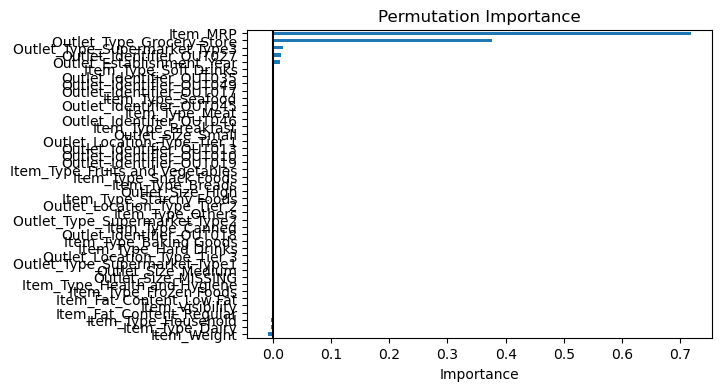

<AxesSubplot: title={'center': 'Permutation Importance'}, xlabel='Importance'>

In [39]:
# Use our plot_importances function, but change title to "Permutation Importance"
plot_importances(rf_perm_importances, title='Permutation Importance')

### LinearRegression Permutation Importance

In [40]:
## run performatation_importance on the lin_reg  using the test data and random_state=SEED
results_linreg = permutation_importance(lin_reg_final, X_test, y_test, scoring='r2', random_state=SEED)
results_linreg.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

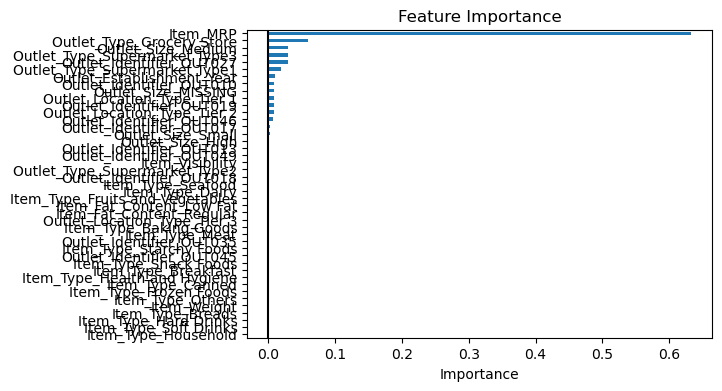

<AxesSubplot: title={'center': 'Feature Importance'}, xlabel='Importance'>

In [41]:
## Make into a series called perm_importances_linreg
linreg_perm_importances = pd.Series(results_linreg['importances_mean'], 
                                    index=lin_reg_final.feature_names_in_)

plot_importances(linreg_perm_importances)

## Applying Shap

In [42]:
# Import and init shap
import shap
shap.initjs()

In [43]:
# Take a sample of the training data (nsampel=500, use random_state=SEED)
X_shap = shap.sample(X_train, nsamples = 500, random_state=SEED)
y_shap = y_train.loc[X_shap.index]
X_shap.head()

Item_Weight  Item_Visibility  Item_MRP  Outlet_Establishment_Year  \
8312        16.10         0.034300  253.2356                     2004.0   
5169         9.60         0.014210  188.1872                     2004.0   
5250        20.60         0.030505  212.6244                     2004.0   
5911        20.35         0.054277  117.3466                     2009.0   
5737         6.30         0.127647  207.9270                     1999.0   

      Item_Fat_Content_Low Fat  Item_Fat_Content_Regular  \
8312                       1.0                       0.0   
5169                       0.0                       1.0   
5250                       0.0                       1.0   
5911                       1.0                       0.0   
5737                       1.0                       0.0   

      Item_Type_Baking Goods  Item_Type_Breads  Item_Type_Breakfast  \
8312                     0.0               0.0                  0.0   
5169                     0.0               0.0                  0.0   
5250                     0.0               0.0                  0.0   
5911                     0.0               0.0                  0.0   
5737                     0.0               0.0                  0.0   

      Item_Type_Canned  Item_Type_Dairy  Item_Type_Frozen Foods  \
8312               0.0              0.0                     0.0   
5169               0.0              0.0                     0.0   
5250               0.0              1.0                     0.0   
5911               0.0              0.0                     0.0   
5737               1.0              0.0                     0.0   

      Item_Type_Fruits and Vegetables  Item_Type_Hard Drinks  \
8312                              1.0                    0.0   
5169                              0.0                    0.0   
5250                              0.0                    0.0   
5911                              0.0                    0.0   
5737                              0.0                    0.0   

      Item_Type_Health and Hygiene  Item_Type_Household  Item_Type_Meat  \
8312                           0.0                  0.0             0.0   
5169                           0.0                  0.0             0.0   
5250                           0.0                  0.0             0.0   
5911                           0.0                  0.0             0.0   
5737                           0.0                  0.0             0.0   

      Item_Type_Others  Item_Type_Seafood  Item_Type_Snack Foods  \
8312               0.0                0.0                    0.0   
5169               0.0                0.0                    1.0   
5250               0.0                0.0                    0.0   
5911               0.0                0.0                    1.0   
5737               0.0                0.0                    0.0   

      Item_Type_Soft Drinks  Item_Type_Starchy Foods  \
8312                    0.0                      0.0   
5169                    0.0                      0.0   
5250                    0.0                      0.0   
5911                    0.0                      0.0   
5737                    0.0                      0.0   

      Outlet_Identifier_OUT010  Outlet_Identifier_OUT013  \
8312                       0.0                       0.0   
5169                       0.0                       0.0   
5250                       0.0                       0.0   
5911                       0.0                       0.0   
5737                       0.0                       0.0   

      Outlet_Identifier_OUT017  Outlet_Identifier_OUT018  \
8312                       0.0                       0.0   
5169                       0.0                       0.0   
5250                       0.0                       0.0   
5911                       0.0                       1.0   
5737                       0.0                       0.0   

      Outlet_Identifier_OUT019  Outlet_Identifier_OUT027  \


### Create SHAP explainers for RandomForestRegressor

In [44]:
# Instantiate a Model Explainer with the model
rf_explainer = shap.Explainer(rf_reg)

## Get shap values from the explainer
rf_shap_values = rf_explainer(X_shap) 

In [45]:
rf_shap_values.shape

(500, 43)

### Summary Bar Plots

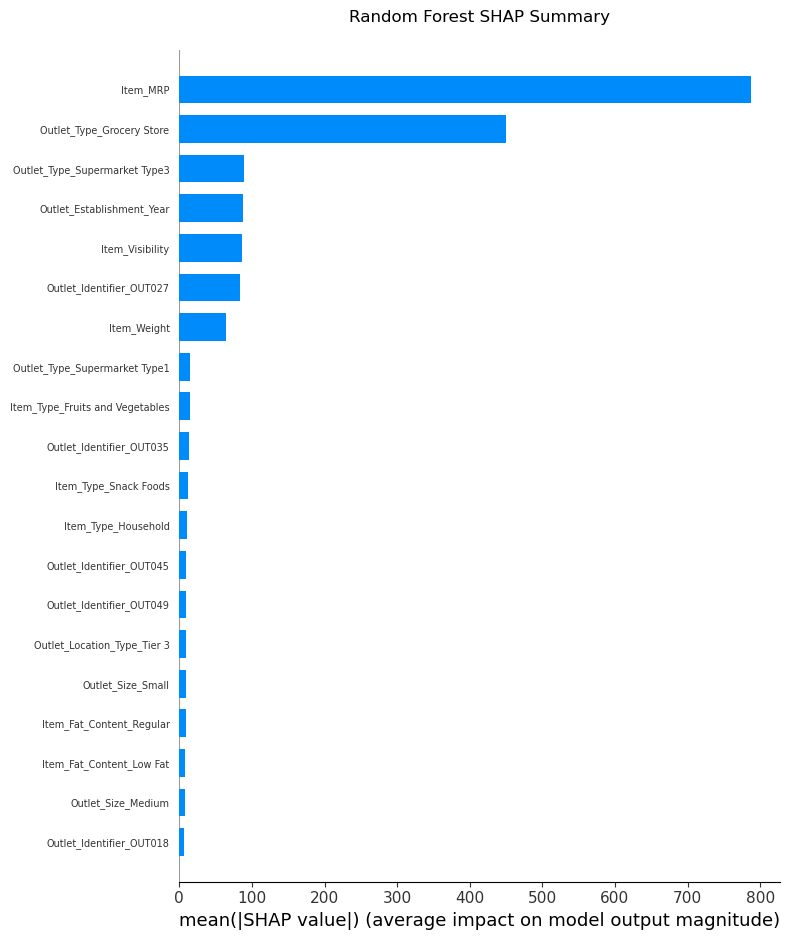

In [74]:
fig, ax = plt.subplots(figsize=(8, 15))
shap.summary_plot(rf_shap_values, features=X_shap, plot_type='bar', show=False)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.7, top=0.9)

ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=7)

# This sets the padding between the top of the plot and the title.
plt.title('Random Forest SHAP Summary', pad=20)

plt.tight_layout()

plt.savefig('ShapImageBar.png', bbox_inches='tight')

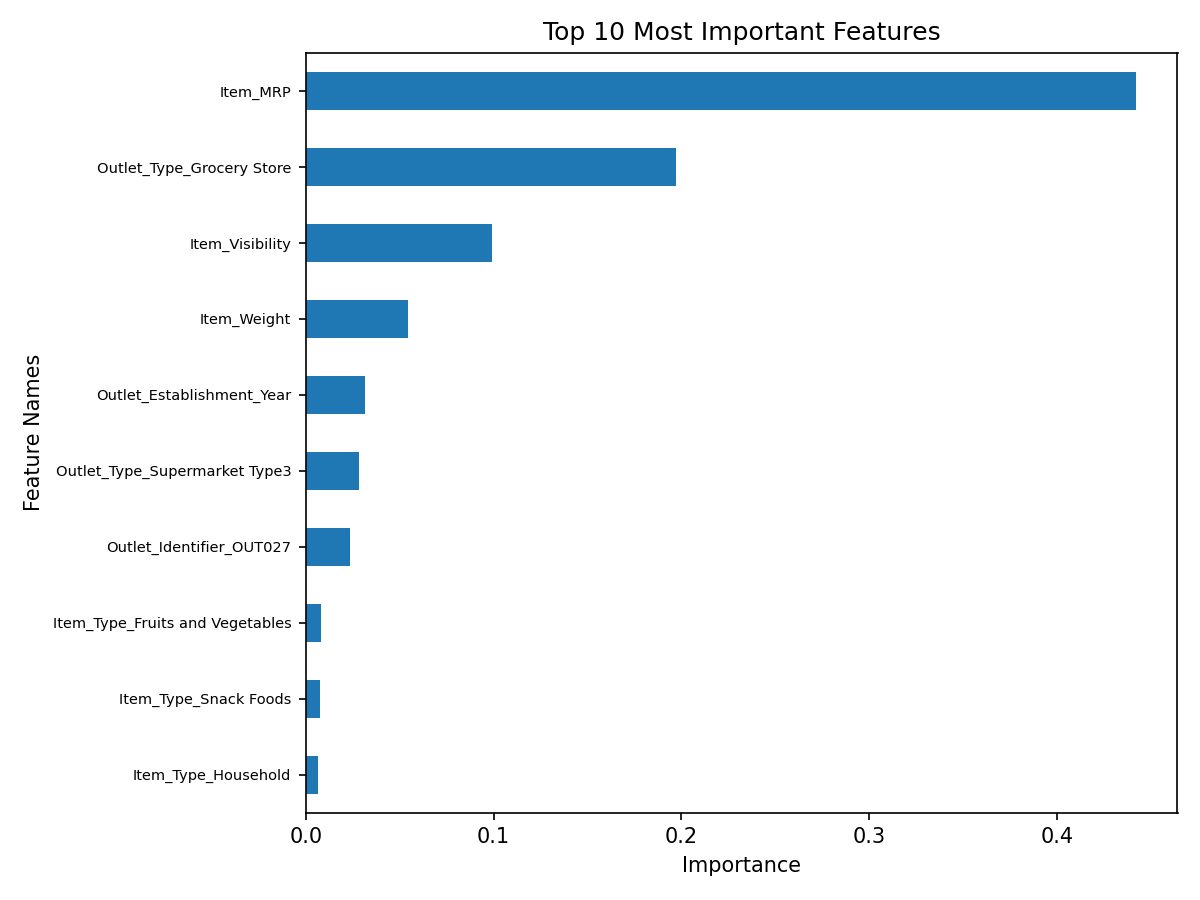

In [71]:
from IPython.display import Image
Image("RandomForestFeatureAnalysis.png")


- Both the SHAP and Feature Importance visualizations demonstrate that the Item_MRP feature has the largest marginal contribution and importance respectively.
- Similarly, both visualizations indicate the Grocery Store type as a feature with a substantial contribution or importance. However, their interpretations start to diverge afterwards.
- The SHAP plot indicates that Supermarket Type 3 makes the third largest marginal contribution towards the predictive value for a particular sample. However, the Feature Importance chart suggests that Item Visibility is the third most important feature when considering overall model performance

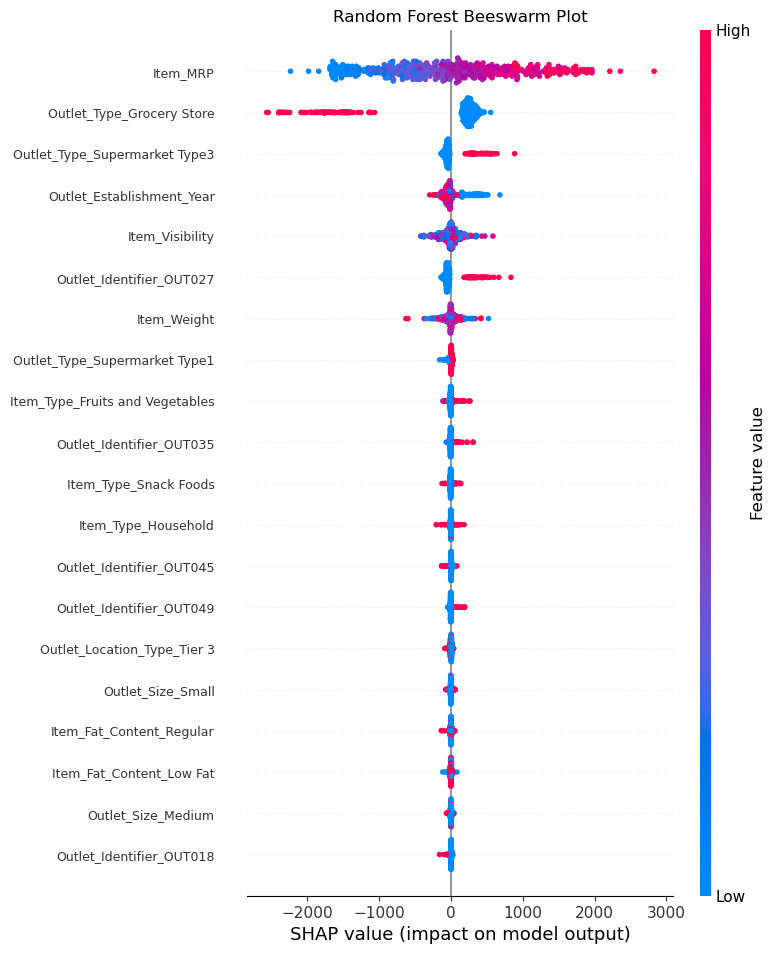

In [77]:
## create a summary plot for Random Forest (dot/default version)
fig, ax = plt.subplots()
shap.summary_plot(rf_shap_values, features=X_shap, show=False)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.7, top=0.9)

ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=9)
plt.tight_layout()

plt.title('Random Forest Beeswarm Plot')
plt.show()

- The feature that contributes the most to the predictive value for a particular sample in this Shap dot chart is definitely Item_MRP.
- It's not about the importance, but rather the magnitude of the Item_MRP's contribution. The higher the value of Item_MRP, the larger its marginal contribution towards the predictive value.
- The second most contributing feature is the Grocery store type. However, remember it's not about the importance or impact of the feature itself. Instead, a lower value of the Outlet Type has a larger marginal contribution towards the prediction.
- Supermarket Type 3 is the third feature with a substantial marginal contribution towards the predictive value. Higher values of this feature correspond to larger contributions, not necessarily to higher importance or impact.

In [80]:
fig.savefig('ShapImageDot.png',dpi=150, bbox_inches='tight');

## Local Explanations

In [88]:
print(X_shap.index[:5])

Int64Index([8312, 5169, 5250, 5911, 5737], dtype='int64')


In [89]:
## Making a vers of shap vars with 0-based integer index 
# so what it matches the index for the shap_vallues
X_shap_local = X_shap.reset_index(drop=True)
y_shap_local = y_shap.reset_index(drop=True)
X_shap_local.head()

Item_Weight  Item_Visibility  Item_MRP  Outlet_Establishment_Year  \
0        16.10         0.034300  253.2356                     2004.0   
1         9.60         0.014210  188.1872                     2004.0   
2        20.60         0.030505  212.6244                     2004.0   
3        20.35         0.054277  117.3466                     2009.0   
4         6.30         0.127647  207.9270                     1999.0   

   Item_Fat_Content_Low Fat  Item_Fat_Content_Regular  Item_Type_Baking Goods  \
0                       1.0                       0.0                     0.0   
1                       0.0                       1.0                     0.0   
2                       0.0                       1.0                     0.0   
3                       1.0                       0.0                     0.0   
4                       1.0                       0.0                     0.0   

   Item_Type_Breads  Item_Type_Breakfast  Item_Type_Canned  Item_Type_Dairy  \
0               0.0                  0.0               0.0              0.0   
1               0.0                  0.0               0.0              0.0   
2               0.0                  0.0               0.0              1.0   
3               0.0                  0.0               0.0              0.0   
4               0.0                  0.0               1.0              0.0   

   Item_Type_Frozen Foods  Item_Type_Fruits and Vegetables  \
0                     0.0                              1.0   
1                     0.0                              0.0   
2                     0.0                              0.0   
3                     0.0                              0.0   
4                     0.0                              0.0   

   Item_Type_Hard Drinks  Item_Type_Health and Hygiene  Item_Type_Household  \
0                    0.0                           0.0                  0.0   
1                    0.0                           0.0                  0.0   
2                    0.0                           0.0                  0.0   
3                    0.0                           0.0                  0.0   
4                    0.0                           0.0                  0.0   

   Item_Type_Meat  Item_Type_Others  Item_Type_Seafood  Item_Type_Snack Foods  \
0             0.0               0.0                0.0                    0.0   
1             0.0               0.0                0.0                    1.0   
2             0.0               0.0                0.0                    0.0   
3             0.0               0.0                0.0                    1.0   
4             0.0               0.0                0.0                    0.0   

   Item_Type_Soft Drinks  Item_Type_Starchy Foods  Outlet_Identifier_OUT010  \
0                    0.0                      0.0                       0.0   
1                    0.0                      0.0                       0.0   
2                    0.0                      0.0                       0.0   
3                    0.0                      0.0                       0.0   
4                    0.0                      0.0                       0.0   

   Outlet_Identifier_OUT013  Outlet_Identifier_OUT017  \
0                       0.0                       0.0   
1                       0.0                       0.0   
2                       0.0                       0.0   
3                       0.0                       0.0   
4                       0.0                       0.0   

   Outlet_Identifier_OUT018  Outlet_Identifier_OUT019  \
0                       0.0                       0.0   
1                       0.0                       0.0   
2                       0.0                       0.0   
3                       1.0                       0.0   
4                       0.0                       0.0   

   Outlet_Identifier_OUT027  Outlet_Identifier_OUT035  \
0                       0.0                       1.0  

### High MRP

In [90]:
# what is the max/range of Item_MRP
X_shap_local['Item_MRP'].describe()

count    500.000000
mean     138.157716
std       60.897346
min       32.655800
25%       93.172500
50%      141.265400
75%      181.390350
max      266.188400
Name: Item_MRP, dtype: float64

In [91]:
## saving the index of the most MRP
idx_high_mrp = X_shap_local['Item_MRP'].idxmax()
idx_high_mrp

231

In [92]:
# checking the feature values for selected example
X_shap_local.iloc[idx_high_mrp]

Item_Weight                          19.850000
Item_Visibility                       0.005243
Item_MRP                            266.188400
Outlet_Establishment_Year          1999.000000
Item_Fat_Content_Low Fat              1.000000
Item_Fat_Content_Regular              0.000000
Item_Type_Baking Goods                0.000000
Item_Type_Breads                      0.000000
Item_Type_Breakfast                   0.000000
Item_Type_Canned                      0.000000
Item_Type_Dairy                       1.000000
Item_Type_Frozen Foods                0.000000
Item_Type_Fruits and Vegetables       0.000000
Item_Type_Hard Drinks                 0.000000
Item_Type_Health and Hygiene          0.000000
Item_Type_Household                   0.000000
Item_Type_Meat                        0.000000
Item_Type_Others                      0.000000
Item_Type_Seafood                     0.000000
Item_Type_Snack Foods                 0.000000
Item_Type_Soft Drinks                 0.000000
Item_Type_Sta

In [93]:
## what was the actual MRP?
y_shap_local.iloc[idx_high_mrp]

3179.8608

#### Shap Force Plot

In [94]:
## plotting example force plot for highest MRP (from rf)
shap.force_plot(rf_explainer.expected_value,
               shap_values=rf_shap_values[idx_high_mrp].values,
               features = X_shap_local.iloc[idx_high_mrp])

- The base value is 2,145.
- The SHAP value is 3,424.20.
- The features that are making the most substantial positive contributions to the prediction are:
> - Outlet Type 0 and Item MRP with a contribution of 266.2 to the Outlet_sales prediction.
- The features that make substantial negative contributions, reducing the final Outlet_sales prediction, include:
> - Item visibility of 0.005 and the Outlet establishment year. Please note that a negative contribution does not mean these features "lost"; they simply contributed in a way that reduced the final predicted value.

#### LIME

In [95]:
## Create a lime explainer with X_shap_local with regression as the mode
## Don't need to show it the model yet.
lime_explainer = LimeTabularExplainer(training_data=X_shap_local.values,
                                      feature_names = X_shap_local.columns,
                                      mode='regression')

lime_explainer

In [96]:
## Use the lime explainer to explain the selected example used above 
exp = lime_explainer.explain_instance(X_shap_local.loc[idx_high_mrp],
                                      rf_reg.predict)
exp.show_in_notebook()

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


- The model guessed that the value would be near the lowest possible outcome, 66.06.
- LIME helps us understand why the model made its guess. It showed us that for this guess, the type of Grocery Store and the Item MRP mattered the most. It doesn't mean they are always the most important factors, but they were for this particular guess.

### High Visibility

In [98]:
# what is the max/range of Visibility
X_shap_local['Item_Visibility'].describe()

count    500.000000
mean       0.069633
std        0.050303
min        0.000000
25%        0.030553
50%        0.060461
75%        0.096495
max        0.306543
Name: Item_Visibility, dtype: float64

In [99]:
## saving the index of the most Visibility
idx_high_vis = X_shap_local['Item_Visibility'].idxmax()
idx_high_vis

331

In [100]:
# checking the feature values for selected example
X_shap_local.iloc[idx_high_vis]

Item_Weight                          12.852984
Item_Visibility                       0.306543
Item_MRP                            147.310200
Outlet_Establishment_Year          1985.000000
Item_Fat_Content_Low Fat              1.000000
Item_Fat_Content_Regular              0.000000
Item_Type_Baking Goods                0.000000
Item_Type_Breads                      0.000000
Item_Type_Breakfast                   0.000000
Item_Type_Canned                      0.000000
Item_Type_Dairy                       0.000000
Item_Type_Frozen Foods                0.000000
Item_Type_Fruits and Vegetables       0.000000
Item_Type_Hard Drinks                 0.000000
Item_Type_Health and Hygiene          0.000000
Item_Type_Household                   0.000000
Item_Type_Meat                        0.000000
Item_Type_Others                      0.000000
Item_Type_Seafood                     0.000000
Item_Type_Snack Foods                 0.000000
Item_Type_Soft Drinks                 1.000000
Item_Type_Sta

In [101]:
## what was the actual visibility of the item?
y_shap_local.iloc[idx_high_vis]

291.6204

#### Shap Force Plot

In [102]:
## plotting example force plot for highest MRP (from rf)
shap.force_plot(rf_explainer.expected_value,
               shap_values=rf_shap_values[idx_high_vis].values,
               features = X_shap_local.iloc[idx_high_vis])

- The base value is 2,145.
- The SHAP value is 361.28.
- The features that make substantial positive contributions to the Outlet_sales prediction include:
> - Outlet Type Grocery Store 1. Please note that a positive contribution doesn't mean "winning"; it simply means that this feature increases the prediction value.
- The features that make substantial negative contributions to the Outlet_sales prediction include:
> - Outlet Establishment Year 1985. This doesn't mean the feature "lost" in making the prediction; rather, its contribution decreases the final predicted value.

#### LIME

In [103]:
## Use the lime explainer to explain the selected example used above 
exp = lime_explainer.explain_instance(X_shap_local.loc[idx_high_vis],
                                      rf_reg.predict)
exp.show_in_notebook()

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


- The model predicted a value near the lowest possible, which is 61.99.
- Using LIME to understand why the model made its guess, it turned out that Outlet Type Grocery Store, Item MRP, the year being 1985, and the Item Types 'Others' and 'Hard Drinks' were the most influential for this particular prediction. 
- These features played a big part in leading to the low guess, but that doesn't mean they always will for every prediction.